In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
from PIL import Image
import random 
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as tr
from torch.utils.data import random_split


from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator


device = torch.device("cpu")

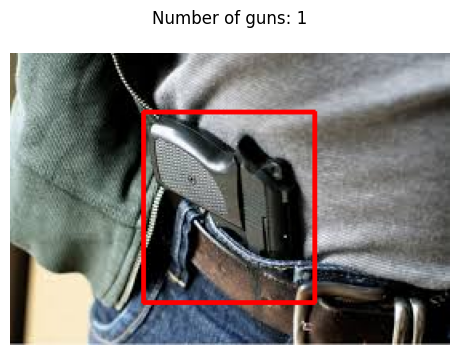

In [3]:
def imshow(number, title = None, size = 5):
    root = "data/"

    image = cv2.imread(root + "Images/" + str(number) + ".jpeg")
    file = open(root + "Labels/" + str(number) + ".txt", "r")
    txt_data = file.readlines()
    file.close()

    for i in range(0, int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0], indices[1])
        end_point = (indices[2], indices[3])
        cv2.rectangle(image, start_point, end_point, (0, 0, 255), 2)
    aspect_ratio = image.shape[0] / image.shape[1]
    plt.figure(figsize = (size + aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title + txt_data[0])
    plt.axis("off")
    plt.show()
number = random.randint(1, 334)
imshow(number, title = "Number of guns: ")

In [4]:
class GunData(Dataset):
    def __init__(self, root):
        self.image_paths = root + "Images/"
        self.labels_paths = root + "Labels/"

        self.img_name = [img for img in sorted(os.listdir(self.image_paths))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_paths))]

    def __getitem__(self,idx):
        image_paths = os.path.join(self.image_paths, str(self.img_name[idx]))
        image = cv2.imread(image_paths)

        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = img_rgb / 255
        img_res = torch.as_tensor(img_res).permute(2, 0, 1)
        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_paths, str(label_name))
        label_path = os.path.join(self.labels_paths, str(label_name))
        with open (label_path, "r") as file:
            l_count = int(file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, file.readline().split())))
        target = {}
        area = []
        labels = []

        for i in range(len(box)):
            labels.append(1)
        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area) 
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64)

        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)
        return img_res, target
    
    def __len__(self):
        return len(self.img_name)

In [5]:
num_epoch = 10

In [6]:
class Model():
    def __init__(self, num):
        self.num = num
        self.model = self.create_model()
    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num)
        return model
    def compiler(self,optimizer):
        self.optimizer=optimizer
    def train(self,train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model=self.model.to(device)
            train_loss = 0
            self.model.train()
            for img, target in train_data:
                loss_dic = self.model(img, target)
                loss = sum(loss for loss in loss_dic.values())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss
            print("Epoch: {} | Train Loss: {}".format(epoch+1, train_loss))
            

In [7]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [ ]:
rcnn = Model(2)
model = rcnn.model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset= GunData("data/")

train_size = int(0.8 * len(dataset))
val_size = len(dataset)-train_size
train_dataset, val_dataset= random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn)

rcnn.train(train_loader, val_loader)


In [13]:
model.load_state_dict(torch.load("model.pt", map_location = torch.device("cpu")))

model = model.to(device)


def test(data, number = random.randint(1, 334)):
    img, target = data[number]
    model.eval()
    predictions = model([img])
    predictions = [{k:v.to(device) for k, v in t.items()} for t in predictions]
    return predictions, target, img
def apply_nms(orig_prediction, iou_thresh=None):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return tr.ToPILImage()(img).convert('RGB')

def plot_img_bbox(img, target, size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    for box in target['boxes']:
        x, y, width, height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x + width), int(y + height)), (0, 0, 255), 2)
        
    aspect_ratio=img_cv.shape[0]/img_cv.shape[1]
    plt.figure(figsize=(size+aspect_ratio,size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show()

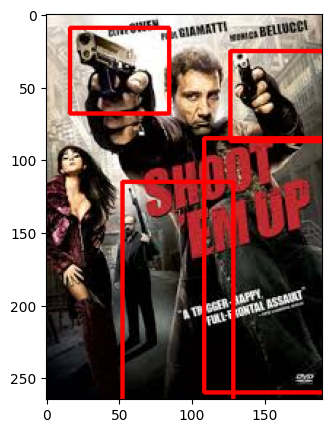

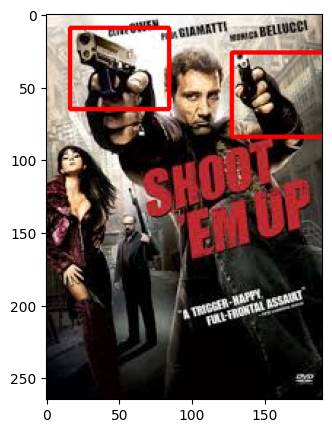

In [14]:
outputs, ground, img = test(dataset, number=10)
nms_prediction = apply_nms(outputs[0], iou_thresh=0.7)

plot_img_bbox(torch_to_pil(img), nms_prediction)
plot_img_bbox(torch_to_pil(img), ground)